In [ ]:
!nvidia-smi

Fri Jul 22 15:13:41 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
%%capture
!pip install transformers
!pip install pytorch-lightning
!pip install torchmetrics

In [ ]:
from google.colab import drive
drive.mount("content/drive")

Mounted at content/drive


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns

from transformers import BertTokenizer,BertModel,AdamW,get_linear_schedule_with_warmup

#from pytorch_lightning.metrics.functional import accuracy, f1, auroc
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from torchmetrics import AUROC

import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
from sklearn.model_selection import train_test_split

import pytorch_lightning as pl


import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
!gdown --id 1VuQ-U7TtggShMeuRSA_hzC8qGDl2LRkr

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1VuQ-U7TtggShMeuRSA_hzC8qGDl2LRkr
To: /content/toxic_comments.csv
100% 68.8M/68.8M [00:00<00:00, 160MB/s]


In [ ]:
file_path = "/content/toxic_comments.csv"

df = pd.read_csv(file_path)
df.head(1)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0


In [ ]:
train_df,val_df = train_test_split(df,test_size = 0.05)
train_df.shape,val_df.shape

((151592, 8), (7979, 8))

In [ ]:
LABEL_COLUMNS = ['toxic', 'severe_toxic', 'obscene', 'threat','insult', 'identity_hate']

train_df[LABEL_COLUMNS].sum()

toxic            14500
severe_toxic      1534
obscene           8014
threat             456
insult            7484
identity_hate     1330
dtype: int64

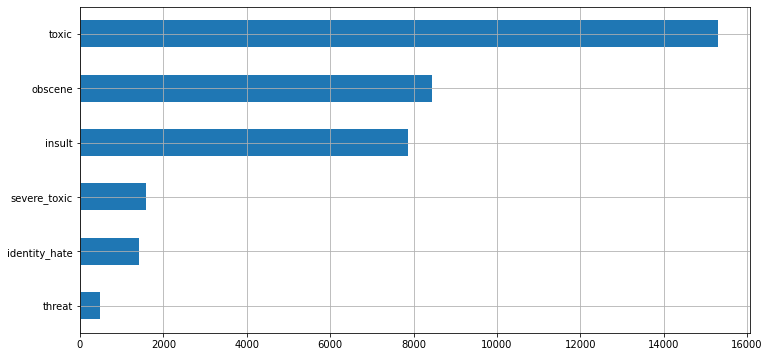

In [ ]:
plt.figure(figsize = (12,6))
df[LABEL_COLUMNS].sum().sort_values().plot(kind = "barh")
plt.grid()
plt.show()

In [ ]:
train_df[LABEL_COLUMNS].sum().sum()

33318

In [ ]:
train_toxic = train_df[train_df[LABEL_COLUMNS].sum(axis = 1) > 0]
train_clean = train_df[train_df[LABEL_COLUMNS].sum(axis = 1) == 0]
train_clean.shape,train_toxic.shape

((136196, 8), (15396, 8))

<Figure size 864x360 with 0 Axes>

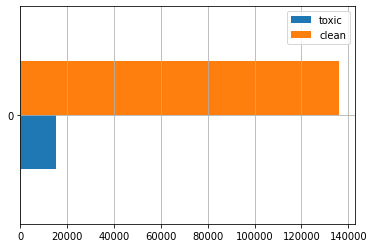

In [ ]:
plt.figure(figsize = (12,5))

pd.DataFrame(dict(
    toxic = [len(train_toxic)],
    clean = [len(train_clean)]
)).plot(kind = "barh");

plt.grid()
plt.show()

In [ ]:
train_df = pd.concat([
                      train_toxic,
                      train_clean.sample(15_000)
])
train_df.shape,val_df.shape

((30396, 8), (7979, 8))

# Tokenization

In [ ]:
BERT_MODEL_NAME = "bert-base-cased"
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)

In [ ]:
sample_row = df.iloc[16]
sample_comment = sample_row.comment_text
sample_labels = sample_row[LABEL_COLUMNS]

print(sample_comment)
print()
print(sample_labels.to_dict())

Bye! 

Don't look, come or think of comming back! Tosser.

{'toxic': 1, 'severe_toxic': 0, 'obscene': 0, 'threat': 0, 'insult': 0, 'identity_hate': 0}


In [ ]:
encoding = tokenizer.encode_plus(
    sample_comment,
    add_special_tokens = True,
    max_length = 512,
    return_token_type_ids = False,
    padding = "max_length",
    return_attention_mask = True,
    return_tensors = "pt",   
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [ ]:
for i in encoding.keys():
    print(f"{i} : {encoding[i].shape}")
    print(f"{i} Flatten : {encoding[i].flatten().shape}")
    print()

input_ids : torch.Size([1, 512])
input_ids Flatten : torch.Size([512])

attention_mask : torch.Size([1, 512])
attention_mask Flatten : torch.Size([512])



In [ ]:
print(tokenizer.convert_ids_to_tokens(encoding["input_ids"].squeeze()[:20]))

['[CLS]', 'Bye', '!', 'Don', "'", 't', 'look', ',', 'come', 'or', 'think', 'of', 'com', '##ming', 'back', '!', 'To', '##sser', '.', '[SEP]']


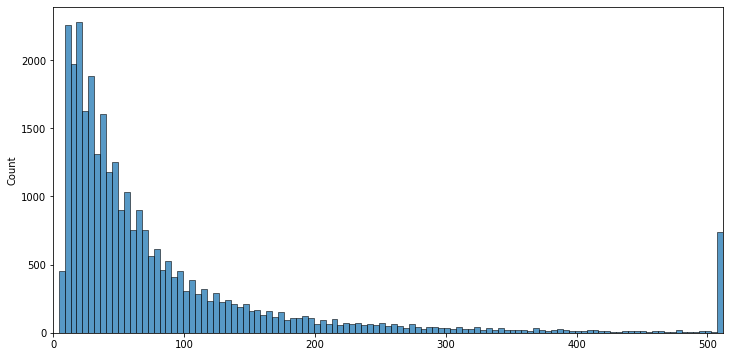

In [ ]:
token_counts = []

for _ ,row in train_df.iterrows():

    token_count = len(tokenizer.encode(
        row["comment_text"],
        max_length = 512,
        truncation = True
    ))
    token_counts.append(token_count)


plt.figure(figsize = (12,6))
sns.histplot(token_counts)
plt.xlim([0,512]);

In [ ]:
MAX_TOKEN_COUNT = 512

In [ ]:
class ToxicCommentsDataset(torch.utils.data.Dataset):

    def __init__(self,
                 data : pd.DataFrame,
                 tokenizer : BertTokenizer, 
                 max_token_len : int = 128):
        
        self.data = data
        self.tokenizer = tokenizer
        self.max_token_len = max_token_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self,index : int):

        data_row = self.data.iloc[index]

        comment_text = data_row.comment_text
        labels = data_row[LABEL_COLUMNS]

        encoding = self.tokenizer.encode_plus(
            comment_text,
            add_special_tokens = True,
            max_length = self.max_token_len,
            padding = "max_length",
            return_attention_mask = True,
            return_token_type_ids = False,
            truncation = True,
            return_tensors = "pt"

        )

        return dict(
            comment_text = comment_text,
            input_ids = encoding["input_ids"].flatten(),
            attention_mask = encoding["input_ids"].flatten(),
            labels = torch.FloatTensor(labels)
        )

In [ ]:
train_dataset = ToxicCommentsDataset(train_df,
                                     tokenizer,
                                     max_token_len = MAX_TOKEN_COUNT)

In [ ]:
sample_item = train_dataset[0]
sample_item.keys()

dict_keys(['comment_text', 'input_ids', 'attention_mask', 'labels'])

In [ ]:
sample_item["input_ids"].shape,sample_item["attention_mask"].shape

(torch.Size([512]), torch.Size([512]))

In [ ]:
sample_item["comment_text"],sample_item["labels"]

('"\n\noo so u got angry for telling truth  about u . ok i m sorry u r not Idiot .  u r extreme Genius . Unique Prodigy  who hav more brain than Mr. Einstein . Now r u happy  ))  )) D D D . i will try to  follow WP:civil as i dont act like Pollitically Correct. but u also need to follow ( or use ur Brain if u really hav one which i think u hav )  whats write in article . u cant be whimsical about any article and with out any 2nd  thought remove other peoples works. Understude Mr Dum... no no  Mr. Prodigy Pebble Contact  Blogsd ! "',
 tensor([1., 0., 0., 0., 1., 0.]))

In [ ]:
bert_model = BertModel.from_pretrained(BERT_MODEL_NAME
                                      ,return_dict = True)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
sample_batch = next(iter(DataLoader(train_dataset,batch_size = 8, num_workers = 2)))
sample_batch["input_ids"].shape,sample_batch["attention_mask"].shape

(torch.Size([8, 512]), torch.Size([8, 512]))

In [ ]:
sample_batch["input_ids"][0][-128:]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
prediction = bert_model(sample_batch["input_ids"],
                        sample_batch["attention_mask"])
prediction.keys()

odict_keys(['last_hidden_state', 'pooler_output'])

In [ ]:
prediction["last_hidden_state"].shape,prediction["pooler_output"].shape

(torch.Size([8, 512, 768]), torch.Size([8, 768]))

In [ ]:
# DataModule !!! 

class ToxicCommentsModule(pl.LightningDataModule):
    
    def __init__(self,train_df,test_df,tokenizer,batch_size = 8,max_token_len = 128):
        super().__init__()

        self.train_df = train_df
        self.test_df = test_df
        self.batch_size = batch_size
        self.max_token_len = max_token_len
        self.tokenizer = tokenizer

    def setup(self,stage = None):

        self.train_dataset = ToxicCommentsDataset(
            self.train_df,
            self.tokenizer,
            self.max_token_len
        )

        
        self.test_dataset = ToxicCommentsDataset(
            self.test_df,
            self.tokenizer,
            self.max_token_len
        )

    def train_dataloader(self):
        return DataLoader(self.train_dataset,
                          batch_size = self.batch_size,
                          shuffle = True,
                          num_workers = 4)
        

    def val_dataloader(self):
        return DataLoader(self.test_dataset,
                          batch_size = self.batch_size,
                          num_workers = 4)            

    def test_dataloader(self):
        return DataLoader(self.test_dataset,
                          batch_size = self.batch_size,
                          num_workers = 4)

In [ ]:
data_module = ToxicCommentsModule(train_df,
                                  val_df,
                                  tokenizer)

# !!!
data_module.setup()

In [ ]:
d = data_module.test_dataset

for i in d :
    print(i.keys())
    break

dict_keys(['comment_text', 'input_ids', 'attention_mask', 'labels'])


In [ ]:
for i in d[0].keys():
    print("Attention Mask : ", d[0]["attention_mask"].shape)
    print("Input Ids : ", d[0]["input_ids"].shape)
    print("Labels : ", d[0]["labels"])
    print("Comment Text : ", d[0]["comment_text"])
    break


Attention Mask :  torch.Size([128])
Input Ids :  torch.Size([128])
Labels :  tensor([0., 0., 0., 0., 0., 0.])
Comment Text :  ALL THE MATERIAL IS WITH JIMMY WALES AND FRED LONG TIME AGO! I HOLD RESPECT FOR THEM NOT REPORTERS THAT ARE HAPPY TO BE SUED SO THEY CAN SELL MORE NEWSPAPERS! SCOTSMAN AND GUARDIAN HAVE IN FAIRNESS NEVER REPEATED THEIR DEFAMATION AS NEITHER HAVE ROSIE COWAN OR MARTIN HANNAN OR THE IRISH INDEPENDANT. IF ANYONE WISHES TO PUBLISH DEFAMATORY MATERIAL THEY WILL BE PROSECUTED UNDER THE CRIMINAL LAW IN ITALY AND SUED IN THE CIVIL COURTS IN WHICHEVER JURISDICTION I DEEM EXPEDIENT. THOSE THAT WRITE RUBBISH ABOUT ME TRY AND USE THE COVER OF WIKIPEDIA AND ARE AFRAID OF USING THEIR OWN NAMES, ADDRESSES AND FULL CONTACT DETAILS. IF ANY EDITOR WISHES TO PUBLISH RUBBISH HAVE THE COURAGE TO IDENTIFY HIMSELF/HERSELF PUBLICLY. EVERYTHING I DO IS PUBLIC AND OPEN-GOOD/BAD/SUCCESS/FAILURE. AS I HAVE STATED ALL THE MATERIAL HAS BEEN WITH JIMMY WALES AND FRED AND ANOTHER EDITOR WHO HA

In [ ]:
train_df.shape,val_df.shape,train_df.shape[0]

((30396, 8), (7979, 8), 30396)

In [ ]:
N_EPOCHS = 10
BATCH_SIZE = 12

data_module = ToxicCommentsModule(
    train_df,
    val_df,
    tokenizer,
    batch_size = BATCH_SIZE)

data_module.setup()
data_module.train_dataset[train_df.shape[0]-1].keys()

dict_keys(['comment_text', 'input_ids', 'attention_mask', 'labels'])

# Modeling

## Evaluation

In [ ]:
criterion = torch.nn.BCELoss() 
softmax_criterion = torch.nn.CrossEntropyLoss()

prediction = torch.FloatTensor([
                                10.12312,1.12312,1.53123,0.00231231,15.12312,1.09123
])

labels = torch.FloatTensor(
    [1.,0.,0.,0.,1.,0.]
)

torch.sigmoid(prediction)

tensor([1.0000, 0.7546, 0.8222, 0.5006, 1.0000, 0.7486])

In [ ]:
output_loss = criterion(torch.sigmoid(prediction), labels)
output_loss

tensor(0.8678)

In [ ]:
softmax_criterion(torch.sigmoid(prediction), labels)

tensor(3.2205)

In [ ]:
bert_model.config.hidden_size

768

In [ ]:
class ToxicCommentTagger(pl.LightningModule):

    def __init__(self,
                 n_classes : int ,
                 n_training_steps = None, 
                 n_warmup_steps = None ):

        super().__init__()

        self.bert = BertModel.from_pretrained(
            BERT_MODEL_NAME,
            return_dict = True
            )
        
        self.classifier = torch.nn.Linear(self.bert.config.hidden_size,n_classes)
        self.n_training_steps = n_training_steps
        self.n_warmup_steps = n_warmup_steps
        self.criterion = torch.nn.BCELoss()

    def forward(self,input_ids, attention_mask, labels = None):

        output = self.bert(input_ids,attention_mask = attention_mask)
        output = self.classifier(output.pooler_output)
        output = torch.nn.functional.sigmoid(output)
        loss = 0 
        if labels is not None:
            loss = self.criterion(output, labels)
        return loss, output

    # Return loss,output !!!!
    def training_step(self,batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]

        loss, outputs = self(input_ids, attention_mask, labels)
        self.log("train_loss", loss, prog_bar = True, logger = True)
        return {"loss" : loss , "predictions" : outputs , "labels" : labels}

        
    def validation_step(self,batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]

        loss, outputs = self(input_ids, attention_mask, labels)
        self.log("val_loss", loss, prog_bar = True, logger = True)
        return loss

    def test_step(self,batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]

        loss, outputs = self(input_ids, attention_mask, labels)
        self.log("test_loss", loss, prog_bar = True, logger = True)
        return loss
    
    def training_epoch_end(self, outputs):
        print("Training Epoch End : ", outputs)
        labels = []
        predictions = []

        print("Outputs : \n", outputs)

        for output in outputs:
            for out_labels in output["labels"].detach().cpu():
                labels.append(out_labels)

            for out_pred in output["predictions"].detach().cpu():
                predictions.append(out_pred)

        labels = torch.stack(labels)
        predictions = torch.stack(predictions)

        #for i,name in enumerate(LABEL_COLUMNS):
        #    roc_score = AUROC(predictions[:,i],labels[:,i])
        #    self.logger.experiment.add_scalars(f"{name}_roc_auc/Train",
        #                                      roc_score,
        #                                      self.current_epoch)
            
    def configure_optimizers(self):

        optimizer = AdamW(self.parameters(), lr = 2e-5)

        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps = self.n_warmup_steps,
            num_training_steps = self.n_training_steps
                    )

        return dict(

            optimizer = optimizer,
            lr_scheduler = dict(
                scheduler = scheduler,
                interval = "step"
            )
        )

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


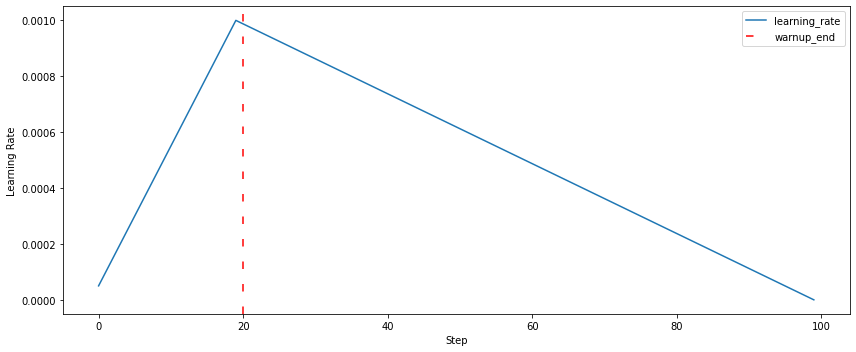

In [ ]:
dummy_model = torch.nn.Linear(2,1)
optimizer = AdamW(params = dummy_model.parameters(), lr = 0.001)

warmup_steps = 20
total_training_steps = 100

schedular = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps = warmup_steps,
    num_training_steps =  total_training_steps
)

learning_rate_history = []

for step in range(total_training_steps):
    optimizer.step()
    schedular.step()
    learning_rate_history.append(optimizer.param_groups[0]["lr"])


plt.figure(figsize = (12,5))
plt.plot(learning_rate_history,label = "learning_rate")
plt.axvline(x = warmup_steps,color = "red", linestyle = (0,(5,10)), label = "warnup_end")
plt.legend()
plt.xlabel("Step")
plt.ylabel("Learning Rate")
plt.tight_layout()
plt.show()

In [ ]:
len(train_df),train_df.shape,BATCH_SIZE,N_EPOCHS

(30396, (30396, 8), 12, 10)

In [ ]:
# Epoch: Epoch is considered as number of one pass from entire dataset
# Steps: In tensorflow or Pytorch one steps is considered as number of epochs multiplied by examples divided by batch size

# According to Google's Machine Learning Glossary, an epoch is defined as
# "A full training pass over the entire dataset such that each example has been seen once.
#  Thus, an epoch represents N/batch_size training iterations, where N is the total number of examples."
# If you are training model for 10 epochs with batch size 6, given total 12 samples that means:
# the model will be able to see whole dataset in 2 iterations ( 12 / 6 = 2) i.e. single epoch.
# overall, the model will have 2 X 10 = 20 iterations (iterations-per-epoch X no-of-epochs)
# re-evaluation of loss and model parameters will be performed after each iteration!

steps_per_epoch = len(train_df) // BATCH_SIZE
total_training_steps = steps_per_epoch * N_EPOCHS
warmup_steps = total_training_steps // 5

steps_per_epoch,total_training_steps,warmup_steps,N_EPOCHS,BATCH_SIZE,len(train_df)

(2533, 25330, 5066, 10, 12, 30396)

In [ ]:
model = ToxicCommentTagger(
    n_classes = len(LABEL_COLUMNS),
    n_warmup_steps = warmup_steps,
    n_training_steps = total_training_steps
    )

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# Train dataset !! 

sample_item.keys(),sample_item["input_ids"].shape,sample_item["attention_mask"].shape

(dict_keys(['comment_text', 'input_ids', 'attention_mask', 'labels']),
 torch.Size([512]),
 torch.Size([512]))

In [ ]:
sample_item["input_ids"].shape

torch.Size([512])

In [ ]:
_ ,predictions = \
model(
    sample_item["input_ids"].unsqueeze(dim = 0),
    sample_item["attention_mask"].unsqueeze(dim = 0)
)

print("Prediction : " , predictions)
print()
print("Prediction Shape : " , predictions.shape)

Prediction :  tensor([[0.6176, 0.5989, 0.4865, 0.4960, 0.5076, 0.5912]],
       grad_fn=<SigmoidBackward0>)

Prediction Shape :  torch.Size([1, 6])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


<Figure size 864x360 with 0 Axes>

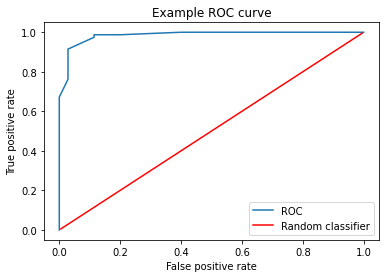

In [ ]:
fpr = [0.        , 0.        , 0.        , 0.02857143, 0.02857143,
       0.11428571, 0.11428571, 0.2       , 0.4       , 1.        ]
tpr = [0.        , 0.01265823, 0.67202532, 0.76202532, 0.91468354,
       0.97468354, 0.98734177, 0.98734177, 1.        , 1.        ]

plt.figure(figsize = (12,5))
_, ax = plt.subplots()
ax.plot(fpr, tpr, label="ROC")
ax.plot([0.05, 0.95], [0.05, 0.95], transform=ax.transAxes, label="Random classifier", color="red")
ax.legend(loc=4)
ax.set_xlabel("False positive rate")
ax.set_ylabel("True positive rate")
ax.set_title("Example ROC curve")
plt.show();

# Training

In [ ]:
from pytorch_lightning.callbacks import ModelCheckpoint,EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

checkpoint_callback = ModelCheckpoint(
                        dirpath = "content/drive/MyDrive/Deep_Learning/BERT&Transformer/BERT/checkpoints/",
                        filename = "best-checkpoint",
                        save_top_k = 1,
                        verbose = True,
                        monitor = "val_loss",
                        mode = "min"
)

In [ ]:
logger = TensorBoardLogger(
    save_dir = "content/drive/MyDrive/Deep_Learning/BERT&Transformer/BERT/lightning_logs/",
    name = "toxic_comments")

early_stopping_callbacks = EarlyStopping(monitor = "val_loss",patience=2)

trainer = pl.Trainer(
                     logger =logger,
                     checkpoint_callback = checkpoint_callback,
                     callbacks = [early_stopping_callbacks],
                     max_epochs = N_EPOCHS,
                     gpus = 1,
                     progress_bar_refresh_rate = 30)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:152: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=<pytorch_lightning.callbacks.model_checkpoint.ModelCheckpoint object at 0x7f7a4804c650>)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=<pytorch_lightning.callbacks.model_checkpoint.ModelCheckpoint object at 0x7f7a4804c650>)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:97: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=30)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Tr

In [ ]:
trainer.fit(model, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,

  | Name       | Type      | Params
-----------------------------------------
0 | bert       | BertModel | 108 M 
1 | classifier | Linear    | 4.6 K 
2 | criterion  | BCELoss   | 0     
-----------------------------------------
108 M     Trainable params
0         Non-trainable params
108 M     Total params
433.260   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training Epoch End :  

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Training Epoch End :  

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:726: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [ ]:
# trainer.test(data_module)
# trainer.test(data_module.test_dataset)
# trainer.test(model,data_module.val_dataloader())

<bound method Trainer.test of <pytorch_lightning.trainer.trainer.Trainer object at 0x7f7a48045350>>

In [ ]:
trained_model = ToxicCommentTagger.load_from_checkpoint(
    trainer.checkpoint_callback.best_model_path,
    n_classes = len(LABEL_COLUMNS)
)


# We set Test mode and reset every thing !!! 
trained_model.eval()
trained_model.freeze()

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# Predictions 

In [ ]:
test_comment = "I really hate you. You are a complete loser. Get out of my house"

encoding = tokenizer.encode_plus(
    test_comment,
    add_special_tokens = True,
    max_length = 128,
    return_token_type_ids = False,
    padding = "max_length",
    return_attention_mask = True,
    return_tensors = "pt"
)

In [ ]:
_,test_predictions = trained_model(
    encoding["input_ids"],
    encoding["attention_mask"]
)
test_predictions

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


tensor([[0.5083, 0.5438, 0.5194, 0.4987, 0.5397, 0.4815]])

In [ ]:
Threshold = 0.5

predicted_labels = []

print("Comment : ",test_comment)
print()

for i,label_name in enumerate(LABEL_COLUMNS):
    label_probability = test_predictions.flatten().numpy()[i]
    if label_probability > Threshold:
        predicted_labels.append(label_name)
        print(f"{label_name} : {label_probability:.4f}")


print()
predicted_labels

Comment :  I really hate you. You are a complete loser. Get out of my house

toxic : 0.5083
severe_toxic : 0.5438
obscene : 0.5194
insult : 0.5397



['toxic', 'severe_toxic', 'obscene', 'insult']

# Evaluation

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def classify(comment_text,model,tokenizer,label_names,thresholds = 0.5,device):
    
    encoding = tokenizer.encode_plus(
        test_comment,
        add_special_tokens = True,
        max_length = 128,
        return_token_type_ids = False,
        padding = "max_length",
        return_attention_mask = True,
        return_tensors = "pt"
    )

    _,predictions = model(
        encoding["input_ids"].to(device),
        encoding["attention_mask"].to(device)
    )
    
    print("Comment : ", test_comment)
    print()

    predicted_labels = []

    predictions = predictions.detach().to("cpu").flatten().numpy()

    for i,label_name in enumerate(LABEL_COLUMNS):
        label_probability = predictions[i]
        if label_probability > 0.5:
            predicted_labels.append(label_name)   
            print(f"{label_name} : {label_probability:.4f}")
    
    return predicted_labels

In [ ]:
from warnings import filterwarnings
filterwarnings("ignore")

text = "You are such a loser ! You'll regret everything you've done to me!"

result = classify(text,model,tokenizer,LABEL_COLUMNS,device)

Comment :  I really hate you. You are a complete loser. Get out of my house

severe_toxic : 0.5481
obscene : 0.5137
threat : 0.5262
insult : 0.5495
identity_hate : 0.5070


In [ ]:
from tqdm.auto import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

trained_model = trained_model.to(device)

val_dataset = ToxicCommentsDataset(
    val_df,
    tokenizer,
    max_token_len = MAX_TOKEN_COUNT
)

predictions = []
labels = []

for item in tqdm(val_dataset):
    _,prediction = trained_model(
        item["input_ids"].unsqueeze(dim = 0).to(device),
        item["attention_mask"].unsqueeze(dim = 0).to(device)
    )

    predictions.append(prediction.flatten())
    labels.append(item["labels"].int())

predictions = torch.stack(predictions).detach().cpu()
labels = torch.stack(labels).detach().cpu()

  0%|          | 0/7979 [00:00<?, ?it/s]

In [ ]:
(predictions.shape),(labels.shape)

(torch.Size([7979, 6]), torch.Size([7979, 6]))

In [ ]:
from torchmetrics import Accuracy,AUROC

print("Val Accuracy : {:.4f}".format(Accuracy(threshold = 0.5)(predictions,labels).item()))
print("".center(50,"-"))
print("AUROC : {:.4f}".format(AUROC(num_classes = 6)(predictions,labels).item()))

Val Accuracy : 0.9521
AUROC : 0.8247


In [ ]:
# Important Result For Us !!!! 
print("AUROC per tag\n")
for i, name in enumerate(LABEL_COLUMNS):
  tag_auroc = AUROC(num_classes = 1)(predictions[:,i],labels[:,i]).item()
  print(f"{name.upper()}: {tag_auroc:.4f}")

AUROC per tag

TOXIC: 0.7847
SEVERE_TOXIC: 0.8595
OBSCENE: 0.8046
THREAT: 0.8604
INSULT: 0.8075
IDENTITY_HATE: 0.8316


In [ ]:
from sklearn.metrics import classification_report
y_pred = predictions.numpy()
y_true = labels.numpy()

upper,lower = 1, 0

y_pred = np.where(y_pred > 0.5,upper,lower)

print(
    classification_report(
        y_true,
        y_pred,
        target_names= LABEL_COLUMNS,
        zero_division = 0
    )
)

               precision    recall  f1-score   support

        toxic       0.31      0.55      0.39       794
 severe_toxic       0.00      0.00      0.00        61
      obscene       0.59      0.28      0.38       435
       threat       0.00      0.00      0.00        22
       insult       0.50      0.23      0.32       393
identity_hate       0.00      0.00      0.00        75

    micro avg       0.36      0.36      0.36      1780
    macro avg       0.23      0.18      0.18      1780
 weighted avg       0.39      0.36      0.34      1780
  samples avg       0.05      0.04      0.04      1780

